# Subgroup Discovery Performance vs. Sample Size

# I. Importing libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import norm, sem
from tqdm import tqdm
from lineartree import LinearTreeRegressor
from copy import deepcopy
import xgboost as xgb  
from tabulate import tabulate
from utils.data_loader import *
from utils.methods import *


# II. Experiment Setup

In [ ]:

np.random.seed(103)

def gen_data(n, d, std_in, std_out, beta, R, B):
    X = (B[:, 1] - B[:, 0]) * np.random.rand(n, d) + B[:, 0]
    X = np.concatenate([X, np.ones((n, 1))], axis = 1)
    Y = np.zeros(n)
    for i, x in enumerate(X):
        if in_box(x[:-1], R):
            Y[i] = np.dot(x, beta) + std_in * np.random.randn()
        else:
            Y[i] = std_out * np.random.randn()
    return X, Y


# DDGroup methods
# Get labels from generic threshold
def get_labels(X, Y, g1, g2, std, beta):
    n = len(Y)
    labels = np.zeros(n)
    for k in range(n):
        x = X[k]
        y = Y[k]
        if res(x, y, beta) > std * (g1 * np.linalg.norm(x) + g2):
            labels[k] = 1
    return labels


# LMT methods
# Method for reconstructing bounding box from LMT node
# Input: B, LMT, node
# Output: Region described by node + B
def path_to_node(node, LMT):
    summary = LMT.summary()
    if node == 0:
        return [0]
    else:
        for other_node in summary:
            if node in summary[other_node]['children']:
                parent = other_node
                return path_to_node(parent, LMT) + [node]
        raise Exception(f"Error: Node {node} not found in LMT.")


def node_to_region(node, LMT, B):
    path = path_to_node(node, LMT)
    if len(path) == 1:
        return deepcopy(B)
    
    summary = LMT.summary()
    R_hat = deepcopy(B)
    for i in range(len(path) - 1):
        current_node = path[i]
        next_node = path[i+1]
        assert next_node in summary[current_node]['children'], f"Invalid path: Node {next_node} is not a child of node {current_node}."
        if next_node == summary[current_node]['children'][0]: # Next node is the left child of current node, meaning this split constitutes an *upper* bound
            R_hat[summary[current_node]['col'], 1] = summary[current_node]['th']
        else: # Otherwise, next node is the right child, so this split is a *lower* bound.
            R_hat[summary[current_node]['col'], 0] = summary[current_node]['th']
    
    return R_hat


In [ ]:
# Constants
d = 2
std_in = 0.3
std_out = 5.
bias = 10.

beta = np.array([1., 1., 20.])
R = np.array([[-1/3, 1/3], [-1/3, 1/3]])

B = np.ones((d, 2))
B[:, 0] *= -1


# Experiment parameters & method hyperparams
num_trials = 20
ns = [200, 400, 800, 1600, 3200, 6400]#, 12800]
g1s = [0.]
g2s = [2., 4., 8., 16., 32., 64.]

In [ ]:
import xgboost as xgb  # XGBoost library
def extract_xgboost_regions(xgb_model, X_train, X_val):
    train_leaves = xgb_model.apply(X_train)[:, 0]  # Use leaves from the first tree
    val_leaves = xgb_model.apply(X_val)[:, 0]  # Use leaves from the first tree

    # Loop through each unique leaf and extract the region for each leaf
    regions = []
    unique_leaves = np.unique(train_leaves)
    
    for leaf in unique_leaves:
        # Get the samples assigned to this leaf
        train_samples_in_leaf = X_train[train_leaves == leaf]  # Select rows where leaf matches

        # Define region (exclude the intercept column)
        region = np.zeros((train_samples_in_leaf.shape[1] - 1, 2))  # Shape based on feature count - 1
        for j in range(train_samples_in_leaf.shape[1] - 1):  # Iterate over each feature (column) excluding intercept
            region[j, 0] = np.min(train_samples_in_leaf[:, j])  # min for feature j
            region[j, 1] = np.max(train_samples_in_leaf[:, j])  # max for feature j

        # Convert region to a NumPy array and append
        regions.append(np.array(region))
    
    return regions


# DDGroup Experiment

In [174]:
import warnings
warnings.filterwarnings("ignore")

np.random.seed(100)
res_dict = {n: [] for n in ns}
cluster_res_dict = {n: [] for n in ns}
lmt_res_dict = {n: [] for n in ns}
xgb_res_dict = {n: [] for n in ns} 

for n in tqdm(ns):
    for rep in range(num_trials):
        X, Y = gen_data(n, d, std_in, std_out, beta, R, B)
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=100)

        # DDGroup
        n_core = int(len(Y_train) / 20)
        X_core, Y_core = neighbor_core(X_train, Y_train, n_core)
        beta_hat, _, s_hat = core_fit(X_core, Y_core)
        # print(s_hat)

        valid_regions = []
        for g1 in g1s:
            for g2 in g2s:
                labels = get_labels(X_train, Y_train, g1, g2, s_hat, beta_hat)
                R_hat = hard_grow_region(X_train[:, :-1], labels, B, center = np.mean(X_core[:, :-1], axis = 0))
                
                ind_val = in_box(X_val[:, :-1], R_hat)
                X_val_incl = X_val[ind_val]
                Y_val_incl = Y_val[ind_val]

                rmse_val = np.sqrt(np.mean((X_val_incl @ beta_hat - Y_val_incl) ** 2))
                if rmse_val <= 8 * s_hat:
                    valid_regions.append(R_hat)
        
        largest_vol = 0
        for R_hat in valid_regions:
            vol = box_intersection(R_hat, R_hat)
            if vol > largest_vol:
                best_R = R_hat
                largest_vol = vol
        
        res_dict[n].append(best_R)

        
        # k-means
        # Currently, we select the region with lowest validation error, which isn't quite the same as DDGroup
        best_val_mse = np.inf
        for k in range(2, 10):
            kmeans = KMeans(n_clusters=k, random_state=100).fit(X_train)
            best_mse = np.inf
            for i in range(k):
                X_core = X_train[kmeans.labels_ == i]
                Y_core = Y_train[kmeans.labels_ == i]

                if len(Y_core) == 0:
                    continue

                beta_hat, _, s_hat = core_fit(X_core, Y_core)
                mse = np.mean((X_core @ beta_hat - Y_core) ** 2)
                if mse < best_mse:
                    best_cluster = i
                    beta_best = beta_hat
                
                X_best = X_train[kmeans.labels_ == best_cluster]
                R_hat = np.zeros((d, 2))
                for j in range(d):
                    R_hat[j, 0] = min(X_best[:, j])
                    R_hat[j, 1] = max(X_best[:, j])
                
                ind_val = in_box(X_val[:, :-1], R_hat)
                X_val_incl = X_val[ind_val]
                Y_val_incl = Y_val[ind_val]

                mse_val = np.mean((X_val_incl @ beta_hat - Y_val_incl) ** 2)
                if mse_val < best_val_mse:
                    best_cluster_region = R_hat
        
        cluster_res_dict[n].append(best_cluster_region)


        # LMT
        r = []
        for max_depth in range(1, 10):
            regr = LinearTreeRegressor(base_estimator=LinearRegression(), max_depth=max_depth)
            regr.fit(X_train, Y_train)

            info = np.array([[node, value['samples'], value['loss']] for node, value in regr.summary().items() if type(value['models']) is not tuple])
            node_use = int(info[np.argmin(info[:, 2]), 0]) 
            inds_train = (regr.apply(X_train)==node_use)
            inds_val = (regr.apply(X_val)==node_use)
            model_leaf = LinearRegression(n_jobs=-1).fit(X_train[inds_train, :], Y_train[inds_train])
            y_pred_val = model_leaf.predict(X_val[inds_val, :])
            mse_val = mean_squared_error(Y_val[inds_val], y_pred_val) 
            # MSE on validation set
            r.append([mse_val, regr, node_use])

        r = np.array(r)
        # The depth with smallest MSE on validation set
        best_lmt = np.argmin(r[:, 0])
        lmt_res_dict[n].append(node_to_region(r[best_lmt, 2], r[best_lmt, 1], B))
    

 17%|█▋        | 1/6 [02:21<11:49, 141.92s/it]


KeyboardInterrupt: 

In [ ]:
p_array  = np.zeros((len(ns), num_trials))
r_array  = np.zeros((len(ns), num_trials))
f1_array = np.zeros((len(ns), num_trials))

clust_p_array  = np.zeros((len(ns), num_trials))
clust_r_array  = np.zeros((len(ns), num_trials))
clust_f1_array = np.zeros((len(ns), num_trials))

lmt_p_array  = np.zeros((len(ns), num_trials))
lmt_r_array  = np.zeros((len(ns), num_trials))
lmt_f1_array = np.zeros((len(ns), num_trials))

xgb_p_array  = np.zeros((len(ns), num_trials))
xgb_r_array  = np.zeros((len(ns), num_trials))
xgb_f1_array = np.zeros((len(ns), num_trials))

for i, n in enumerate(ns):
    # DDGroup
    p_array[i] = [0 if box_intersection(R_hat, R_hat) == 0 else box_intersection(R_hat, R) / box_intersection(R_hat, R_hat) for R_hat in res_dict[n]]
    r_array[i] = [box_intersection(R_hat, R) / box_intersection(R, R) for R_hat in res_dict[n]]
    f1_array[i] = [0 if p + r == 0 else 2 * p * r / (p + r) for p, r in zip(p_array[i], r_array[i])]

    # Clustering
    clust_p_array[i] = [0 if box_intersection(R_hat, R_hat) == 0 else box_intersection(R_hat, R) / box_intersection(R_hat, R_hat) for R_hat in cluster_res_dict[n]]
    clust_r_array[i] = [box_intersection(R_hat, R) / box_intersection(R, R) for R_hat in cluster_res_dict[n]]
    clust_f1_array[i] = [0 if p + r == 0 else 2 * p * r / (p + r) for p, r in zip(clust_p_array[i], clust_r_array[i])]

    # LMT
    lmt_p_array[i] = [0 if box_intersection(R_hat, R_hat) == 0 else box_intersection(R_hat, R) / box_intersection(R_hat, R_hat) for R_hat in lmt_res_dict[n]]
    lmt_r_array[i] = [box_intersection(R_hat, R) / box_intersection(R, R) for R_hat in lmt_res_dict[n]]
    lmt_f1_array[i] = [0 if p + r == 0 else 2 * p * r / (p + r) for p, r in zip(lmt_p_array[i], lmt_r_array[i])]

    # XGBoost (iterate over each XGBoost model's regions)
    for rep in range(num_trials): 
        best_region = None
        best_overlap = 0
        for R_hat in xgb_res_dict[n][rep]:  # Find the region with the highest overlap
            overlap = np.sum(in_box(X_train[:, :-1], R_hat)) 
            if overlap > best_overlap:
                best_overlap = overlap
                best_region = R_hat

        if best_region is not None:
            p = 0 if box_intersection(best_region, best_region) == 0 else box_intersection(best_region, R) / box_intersection(best_region, best_region)
            r = box_intersection(best_region, R) / box_intersection(R, R)
            f1 = 0 if p + r == 0 else 2 * p * r / (p + r)

            xgb_p_array[i, rep] = p
            xgb_r_array[i, rep] = r
            xgb_f1_array[i, rep] = f1 


## 1. F1-values Visualisation

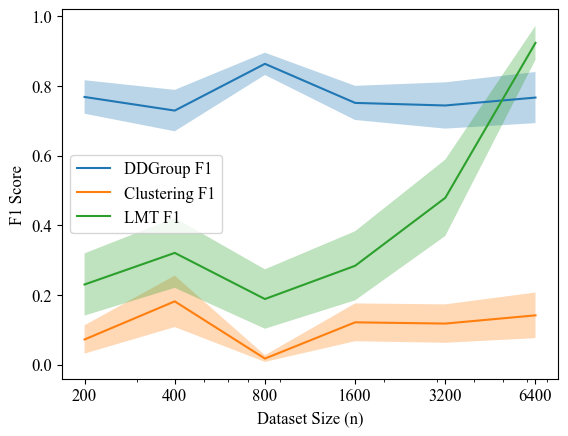

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set up font to match the image
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 12

# Plot F1-scores for all methods excluding XGBoost
plt.plot(ns, np.mean(f1_array, axis=1), label='DDGroup F1')
plt.fill_between(ns, np.mean(f1_array, axis=1) + sem(f1_array, axis=1), np.mean(f1_array, axis=1) - sem(f1_array, axis=1), alpha=0.3)

plt.plot(ns, np.mean(clust_f1_array, axis=1), label='Clustering F1')
plt.fill_between(ns, np.mean(clust_f1_array, axis=1) + sem(clust_f1_array, axis=1), np.mean(clust_f1_array, axis=1) - sem(clust_f1_array, axis=1), alpha=0.3)

plt.plot(ns, np.mean(lmt_f1_array, axis=1), label='LMT F1')
plt.fill_between(ns, np.mean(lmt_f1_array, axis=1) + sem(lmt_f1_array, axis=1), np.mean(lmt_f1_array, axis=1) - sem(lmt_f1_array, axis=1), alpha=0.3)

# Logarithmic x-axis
plt.xscale('log')
plt.xticks(ns, ns)

# Add labels for x and y axes
plt.xlabel('Dataset Size (n)')
plt.ylabel('F1 Score')

# Remove the grid lines
plt.grid(False)

# Add legend
plt.legend()

# Show the plot
plt.show()


### 2. Precision-values plot

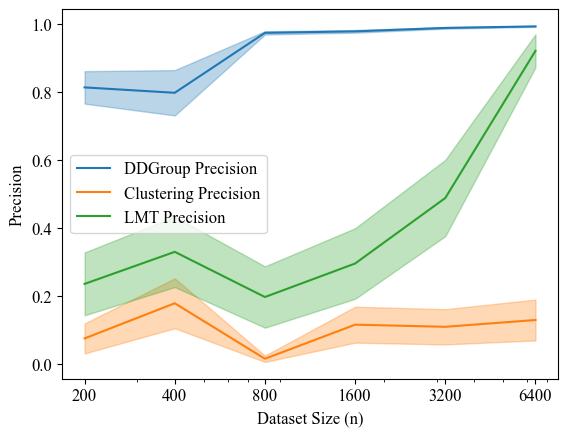

In [ ]:
line = plt.plot(ns, np.mean(p_array, axis=1), label='DDGroup Precision')
plt.fill_between(ns, np.mean(p_array, axis=1) + sem(p_array, axis=1), np.mean(p_array, axis=1) - sem(p_array, axis=1), alpha=0.3, color=line[0].get_color())

line = plt.plot(ns, np.mean(clust_p_array, axis=1), label='Clustering Precision')
plt.fill_between(ns, np.mean(clust_p_array, axis=1) + sem(clust_p_array, axis=1), np.mean(clust_p_array, axis=1) - sem(clust_p_array, axis=1), alpha=0.3, color=line[0].get_color())

line = plt.plot(ns, np.mean(lmt_p_array, axis=1), label='LMT Precision')
plt.fill_between(ns, np.mean(lmt_p_array, axis=1) + sem(lmt_p_array, axis=1), np.mean(lmt_p_array, axis=1) - sem(lmt_p_array, axis=1), alpha=0.3, color=line[0].get_color())

# Formatting to match the previous F1 plot
plt.xscale('log')
plt.xticks(ns, ns)
plt.xlabel("Dataset Size (n)")
plt.ylabel("Precision")
plt.legend()
plt.show()


### 3. Recall-values plot

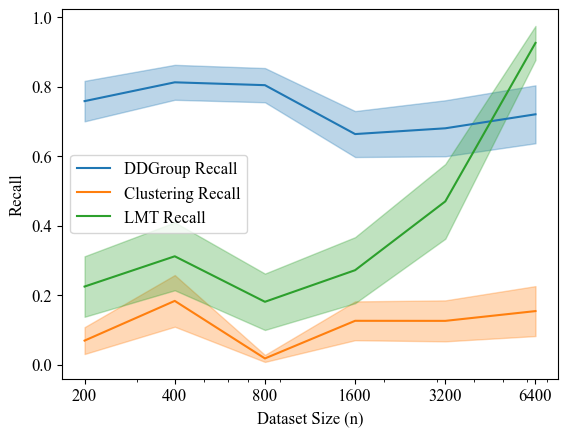

In [ ]:
line = plt.plot(ns, np.mean(r_array, axis=1), label='DDGroup Recall')
plt.fill_between(ns, np.mean(r_array, axis=1) + sem(r_array, axis=1), np.mean(r_array, axis=1) - sem(r_array, axis=1), alpha=0.3, color=line[0].get_color())

line = plt.plot(ns, np.mean(clust_r_array, axis=1), label='Clustering Recall')
plt.fill_between(ns, np.mean(clust_r_array, axis=1) + sem(clust_r_array, axis=1), np.mean(clust_r_array, axis=1) - sem(clust_r_array, axis=1), alpha=0.3, color=line[0].get_color())

line = plt.plot(ns, np.mean(lmt_r_array, axis=1), label='LMT Recall')
plt.fill_between(ns, np.mean(lmt_r_array, axis=1) + sem(lmt_r_array, axis=1), np.mean(lmt_r_array, axis=1) - sem(lmt_r_array, axis=1), alpha=0.3, color=line[0].get_color())

# Formatting to match the previous F1 plot
plt.xscale('log')
plt.xticks(ns, ns)
plt.xlabel("Dataset Size (n)")
plt.ylabel("Recall")
plt.legend()
plt.show()

### 4. Summary Table

In [ ]:
# Calculate mean and standard error for each method
f1_mean = np.mean(f1_array, axis=1)
f1_sem = sem(f1_array, axis=1)

clust_f1_mean = np.mean(clust_f1_array, axis=1)
clust_f1_sem = sem(clust_f1_array, axis=1)

lmt_f1_mean = np.mean(lmt_f1_array, axis=1)
lmt_f1_sem = sem(lmt_f1_array, axis=1)

# Create a list of lists for the table data
table_data = []
for i, n in enumerate(ns):
    table_data.append([
        n,
        f"{f1_mean[i]:.2f} ± {f1_sem[i]:.2f}",
        f"{clust_f1_mean[i]:.2f} ± {clust_f1_sem[i]:.2f}",
        f"{lmt_f1_mean[i]:.2f} ± {lmt_f1_sem[i]:.2f}"
    ])

# Create the table headers
headers = ["Sample Size", "DDGroup F1", "Clustering F1", "LMT F1"]

# Generate the Markdown table using the tabulate library
table = tabulate(table_data, headers=headers, tablefmt="pipe")

# Print the table
print(table)

|   Sample Size | DDGroup F1   | Clustering F1   | LMT F1      |
|--------------:|:-------------|:----------------|:------------|
|           200 | 0.77 ± 0.05  | 0.07 ± 0.04     | 0.23 ± 0.09 |
|           400 | 0.73 ± 0.06  | 0.18 ± 0.07     | 0.32 ± 0.10 |
|           800 | 0.86 ± 0.03  | 0.02 ± 0.01     | 0.19 ± 0.09 |
|          1600 | 0.75 ± 0.05  | 0.12 ± 0.05     | 0.28 ± 0.10 |
|          3200 | 0.74 ± 0.07  | 0.12 ± 0.06     | 0.48 ± 0.11 |
|          6400 | 0.77 ± 0.07  | 0.14 ± 0.07     | 0.92 ± 0.05 |


# IV. New method - XGBoost 

### **XGBoost Region Extraction Process**
The regions extracted from XGBoost are defined by the boundaries of the data points assigned to each leaf in the decision tree. The leaves are used to segment the feature space, and regions are formed by finding the minimum and maximum values for each feature.


### **Main Loop: XGBoost Integration**
For each dataset size `n` and each trial, we:
- Generate data using the `gen_data()` function.
- Split the data into training and validation sets.
- Train the XGBoost model using `train_xgboost()`.
- Extract the regions for the validation set using the leaf structure of the XGBoost model.


# XGBoost and GBM

In [498]:
def extract_xgboost_regions(xgb_model, X_train, X_val):
    """
    Extract multiple regions from XGBoost using the leaf structure from ALL trees.
    """
    train_leaves = xgb_model.apply(X_train)

    regions = []
    for tree_idx in range(train_leaves.shape[1]):  # Iterate over trees
        unique_leaves = np.unique(train_leaves[:, tree_idx])
        for leaf in unique_leaves:
            train_samples_in_leaf = X_train[train_leaves[:, tree_idx] == leaf]
            region = np.zeros((train_samples_in_leaf.shape[1] - 1, 2))
            for j in range(train_samples_in_leaf.shape[1] - 1):
                region[j, 0] = np.min(train_samples_in_leaf[:, j])
                region[j, 1] = np.max(train_samples_in_leaf[:, j])
            regions.append(np.array(region))

    return regions


def train_xgboost(X_train, Y_train, X_val):
    """
    Train an XGBoost model and extract regions for validation.
    """
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=30,
        max_depth=1,
        learning_rate=0.5,
        gamma=0.8,
        subsample=0.9,
        colsample_bytree=0.7,
        random_state=100,
        reg_lambda=0.1
    )
    xgb_model.fit(X_train, Y_train)
    xgb_regions = extract_xgboost_regions(xgb_model, X_train, X_val)
    return xgb_regions


In [499]:
def extract_gbm_regions(gbm_model, X_train, X_val):
    """
    Extract multiple regions from GBM using the leaf structure from the trees.
    """
    # Apply the model to training data to get the leaf indices (use the first tree)
    train_leaves = gbm_model.apply(X_train)[:, 0]  

    # Loop through each unique leaf and extract the region for each leaf
    regions = []
    unique_leaves = np.unique(train_leaves)

    for leaf in unique_leaves:
        # Get the samples assigned to this leaf
        train_samples_in_leaf = X_train[train_leaves == leaf]

        # Define region (exclude the intercept column)
        region = np.zeros((train_samples_in_leaf.shape[1] - 1, 2))
        for j in range(train_samples_in_leaf.shape[1] - 1):
            region[j, 0] = np.min(train_samples_in_leaf[:, j])
            region[j, 1] = np.max(train_samples_in_leaf[:, j])

        regions.append(np.array(region))

    return regions

# GBM functions
def train_gbm(X_train, Y_train, X_val):
    """
    Train a GBM model and extract regions for validation.
    """
    gbm_model = GradientBoostingRegressor(
        n_estimators=30,      # Increased number of estimators
        max_depth=1,            # Adjusted max_depth
        learning_rate=0.05,     # Lowered learning rate
        subsample=0.9,          # Adjusted subsample
        random_state=40,
        loss='huber'            # Use Huber loss function
    )
    
    gbm_model.fit(X_train, Y_train)
    gbm_regions = extract_gbm_regions(gbm_model, X_train, X_val)  # Now returns a list of regions
    return gbm_regions

# One Class SVM 



In [500]:
import warnings
warnings.filterwarnings("ignore")

np.random.seed(100)
res_dict = {n: [] for n in ns}
cluster_res_dict = {n: [] for n in ns}
lmt_res_dict = {n: [] for n in ns}
xgb_res_dict = {n: [] for n in ns} 
svm_res_dict = {n: [] for n in ns} 

for n in tqdm(ns):
    for rep in range(num_trials):
        X, Y = gen_data(n, d, std_in, std_out, beta, R, B)
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=100)

        # DDGroup
        n_core = int(len(Y_train) / 20)
        X_core, Y_core = neighbor_core(X_train, Y_train, n_core)
        beta_hat, _, s_hat = core_fit(X_core, Y_core)
        # print(s_hat)

        valid_regions = []
        for g1 in g1s:
            for g2 in g2s:
                labels = get_labels(X_train, Y_train, g1, g2, s_hat, beta_hat)
                R_hat = hard_grow_region(X_train[:, :-1], labels, B, center = np.mean(X_core[:, :-1], axis = 0))
                
                ind_val = in_box(X_val[:, :-1], R_hat)
                X_val_incl = X_val[ind_val]
                Y_val_incl = Y_val[ind_val]

                rmse_val = np.sqrt(np.mean((X_val_incl @ beta_hat - Y_val_incl) ** 2))
                if rmse_val <= 8 * s_hat:
                    valid_regions.append(R_hat)
        
        largest_vol = 0
        for R_hat in valid_regions:
            vol = box_intersection(R_hat, R_hat)
            if vol > largest_vol:
                best_R = R_hat
                largest_vol = vol
        
        res_dict[n].append(best_R)

        
        # # k-means
        # # Currently, we select the region with lowest validation error, which isn't quite the same as DDGroup
        # best_val_mse = np.inf
        # for k in range(2, 10):
        #     kmeans = KMeans(n_clusters=k, random_state=100).fit(X_train)
        #     best_mse = np.inf
        #     for i in range(k):
        #         X_core = X_train[kmeans.labels_ == i]
        #         Y_core = Y_train[kmeans.labels_ == i]

        #         if len(Y_core) == 0:
        #             continue

        #         beta_hat, _, s_hat = core_fit(X_core, Y_core)
        #         mse = np.mean((X_core @ beta_hat - Y_core) ** 2)
        #         if mse < best_mse:
        #             best_cluster = i
        #             beta_best = beta_hat
                
        #         X_best = X_train[kmeans.labels_ == best_cluster]
        #         R_hat = np.zeros((d, 2))
        #         for j in range(d):
        #             R_hat[j, 0] = min(X_best[:, j])
        #             R_hat[j, 1] = max(X_best[:, j])
                
        #         ind_val = in_box(X_val[:, :-1], R_hat)
        #         X_val_incl = X_val[ind_val]
        #         Y_val_incl = Y_val[ind_val]

        #         mse_val = np.mean((X_val_incl @ beta_hat - Y_val_incl) ** 2)
        #         if mse_val < best_val_mse:
        #             best_cluster_region = R_hat
        
        # cluster_res_dict[n].append(best_cluster_region)


        # # LMT
        # r = []
        # for max_depth in range(1, 10):
        #     regr = LinearTreeRegressor(base_estimator=LinearRegression(), max_depth=max_depth)
        #     regr.fit(X_train, Y_train)

        #     info = np.array([[node, value['samples'], value['loss']] for node, value in regr.summary().items() if type(value['models']) is not tuple])
        #     node_use = int(info[np.argmin(info[:, 2]), 0]) 
        #     inds_train = (regr.apply(X_train)==node_use)
        #     inds_val = (regr.apply(X_val)==node_use)
        #     model_leaf = LinearRegression(n_jobs=-1).fit(X_train[inds_train, :], Y_train[inds_train])
        #     y_pred_val = model_leaf.predict(X_val[inds_val, :])
        #     mse_val = mean_squared_error(Y_val[inds_val], y_pred_val) 
        #     # MSE on validation set
        #     r.append([mse_val, regr, node_use])

        # r = np.array(r)
        # # # The depth with smallest MSE on validation set
        # best_lmt = np.argmin(r[:, 0])
        # lmt_res_dict[n].append(node_to_region(r[best_lmt, 2], r[best_lmt, 1], B))
    
        # # XGBoost model
        # xgb_regions = train_xgboost(X_train, Y_train, X_val)
        # xgb_res_dict[n].append(xgb_regions)

        # # Train and extract regions for GBM 
        # gbm_regions = train_gbm(X_train, Y_train, X_val)
        # gbm_res_dict[n].append(gbm_regions)

    

100%|██████████| 6/6 [04:18<00:00, 43.13s/it]


In [501]:
p_array  = np.zeros((len(ns), num_trials))
r_array  = np.zeros((len(ns), num_trials))
f1_array = np.zeros((len(ns), num_trials))

clust_p_array  = np.zeros((len(ns), num_trials))
clust_r_array  = np.zeros((len(ns), num_trials))
clust_f1_array = np.zeros((len(ns), num_trials))

lmt_p_array  = np.zeros((len(ns), num_trials))
lmt_r_array  = np.zeros((len(ns), num_trials))
lmt_f1_array = np.zeros((len(ns), num_trials))

xgb_p_array  = np.zeros((len(ns), num_trials))
xgb_r_array  = np.zeros((len(ns), num_trials))
xgb_f1_array = np.zeros((len(ns), num_trials))

gbm_p_array = np.zeros((len(ns), num_trials))  # Array to store GBM precision
gbm_r_array = np.zeros((len(ns), num_trials))  # Array to store GBM recall
gbm_f1_array = np.zeros((len(ns), num_trials))  # Array to store GBM F1-score


for i, n in enumerate(ns):
    # DDGroup
    p_array[i] = [0 if box_intersection(R_hat, R_hat) == 0 else box_intersection(R_hat, R) / box_intersection(R_hat, R_hat) for R_hat in res_dict[n]]
    r_array[i] = [box_intersection(R_hat, R) / box_intersection(R, R) for R_hat in res_dict[n]]
    f1_array[i] = [0 if p + r == 0 else 2 * p * r / (p + r) for p, r in zip(p_array[i], r_array[i])]

    # Clustering
    clust_p_array[i] = [0 if box_intersection(R_hat, R_hat) == 0 else box_intersection(R_hat, R) / box_intersection(R_hat, R_hat) for R_hat in cluster_res_dict[n]]
    clust_r_array[i] = [box_intersection(R_hat, R) / box_intersection(R, R) for R_hat in cluster_res_dict[n]]
    clust_f1_array[i] = [0 if p + r == 0 else 2 * p * r / (p + r) for p, r in zip(clust_p_array[i], clust_r_array[i])]

    # LMT
    lmt_p_array[i] = [0 if box_intersection(R_hat, R_hat) == 0 else box_intersection(R_hat, R) / box_intersection(R_hat, R_hat) for R_hat in lmt_res_dict[n]]
    lmt_r_array[i] = [box_intersection(R_hat, R) / box_intersection(R, R) for R_hat in lmt_res_dict[n]]
    lmt_f1_array[i] = [0 if p + r == 0 else 2 * p * r / (p + r) for p, r in zip(lmt_p_array[i], lmt_r_array[i])]

    # XGBoost (iterate over each XGBoost model's regions)
    for rep in range(num_trials): 
        best_region = None
        best_overlap = 0
        for R_hat in xgb_res_dict[n][rep]:  # Find the region with the highest overlap
            overlap = np.sum(in_box(X_train[:, :-1], R_hat)) 
            if overlap > best_overlap:
                best_overlap = overlap
                best_region = R_hat

        if best_region is not None:
            p = 0 if box_intersection(best_region, best_region) == 0 else box_intersection(best_region, R) / box_intersection(best_region, best_region)
            r = box_intersection(best_region, R) / box_intersection(R, R)
            f1 = 0 if p + r == 0 else 2 * p * r / (p + r)

            xgb_p_array[i, rep] = p
            xgb_r_array[i, rep] = r
            xgb_f1_array[i, rep] = f1 
            
            
        best_region = None
        best_overlap = 0
        for R_hat in gbm_res_dict[n][rep]:  # Iterate over extracted regions
            overlap = np.sum(in_box(X_train[:, :-1], R_hat)) 
            if overlap > best_overlap:
                best_overlap = overlap
                best_region = R_hat

        if best_region is not None:
            p = 0 if box_intersection(best_region, best_region) == 0 else box_intersection(best_region, R) / box_intersection(best_region, best_region)
            r = box_intersection(best_region, R) / box_intersection(R, R)
            f1 = 0 if p + r == 0 else 2 * p * r / (p + r)

            gbm_p_array[i, rep] = p  # Store GBM precision
            gbm_r_array[i, rep] = r  # Store GBM recall
            gbm_f1_array[i, rep] = f1  # Store GBM F1-score  


In [503]:
from tabulate import tabulate

# Calculate mean and standard error for each method
f1_mean = np.mean(f1_array, axis=1)
f1_sem = sem(f1_array, axis=1)

clust_f1_mean = np.mean(clust_f1_array, axis=1)
clust_f1_sem = sem(clust_f1_array, axis=1)

lmt_f1_mean = np.mean(lmt_f1_array, axis=1)
lmt_f1_sem = sem(lmt_f1_array, axis=1)

xgb_f1_mean = np.mean(xgb_f1_array, axis=1)
xgb_f1_sem = sem(xgb_f1_array, axis=1)

gbm_f1_mean = np.mean(gbm_f1_array, axis=1)
gbm_f1_sem = sem(gbm_f1_array, axis=1)

dt_f1_mean = np.mean(dt_f1_array, axis=1)
dt_f1_sem = sem(dt_f1_array, axis=1)

# Create a list of lists for the table data (include all methods)
table_data = []
for i, n in enumerate(ns):
    table_data.append([
        n,
        f"{f1_mean[i]:.2f} ± {f1_sem[i]:.2f}",
        f"{clust_f1_mean[i]:.2f} ± {clust_f1_sem[i]:.2f}",
        f"{lmt_f1_mean[i]:.2f} ± {lmt_f1_sem[i]:.2f}",
        f"{xgb_f1_mean[i]:.2f} ± {xgb_f1_sem[i]:.2f}",
        f"{gbm_f1_mean[i]:.2f} ± {gbm_f1_sem[i]:.2f}",
    ])

# Create the table headers (include all methods)
headers = ["Sample Size", "DDGroup F1", "Clustering F1", "LMT F1", "XGBoost F1", "GBM F1"]

# Generate the Markdown table using the tabulate library
table = tabulate(table_data, headers=headers, tablefmt="pipe")

# Print the table
print(table)


|   Sample Size | DDGroup F1   | Clustering F1   | LMT F1      | XGBoost F1   | GBM F1      |
|--------------:|:-------------|:----------------|:------------|:-------------|:------------|
|           200 | 0.77 ± 0.05  | 0.07 ± 0.04     | 0.23 ± 0.09 | 0.21 ± 0.00  | 0.28 ± 0.00 |
|           400 | 0.73 ± 0.06  | 0.18 ± 0.07     | 0.32 ± 0.10 | 0.20 ± 0.00  | 0.28 ± 0.00 |
|           800 | 0.86 ± 0.03  | 0.02 ± 0.01     | 0.19 ± 0.09 | 0.20 ± 0.00  | 0.28 ± 0.00 |
|          1600 | 0.75 ± 0.05  | 0.12 ± 0.05     | 0.28 ± 0.10 | 0.20 ± 0.00  | 0.28 ± 0.00 |
|          3200 | 0.74 ± 0.07  | 0.12 ± 0.06     | 0.48 ± 0.11 | 0.21 ± 0.00  | 0.29 ± 0.00 |
|          6400 | 0.77 ± 0.07  | 0.14 ± 0.07     | 0.92 ± 0.05 | 0.23 ± 0.01  | 0.29 ± 0.00 |
